# Hunder the hood
## Simulation of point clouds 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from twirl.utils import *

%config IPCompleter.use_jedi = False

In [2]:
def R(theta, dx, dy, s=1):
    return np.array([
        [s*np.cos(theta), -s*np.sin(theta), s*dx],
        [s*np.sin(theta), s*np.cos(theta), s*dy],
        [0, 0, 1],
    ])

In [3]:
# We generate data and apply an affine transform to have the second dataset

np.random.seed(42)

r = R(np.pi*np.random.rand(), 1000, 100, 2)
n = 30
s1 = np.random.rand(2, n)*100
s2 = s1 + np.random.rand(*s1.shape)
s2 = (r@np.pad(s2, (0, 1))).T[0:-1, 0:-1]
np.random.shuffle(s2)
s2 = s2.T

idxs = np.arange(s1.shape[1])
s1 = s1[:, np.random.choice(idxs, size=20, replace=False)]
s2 = s2[:, np.random.choice(idxs, size=20, replace=False)]

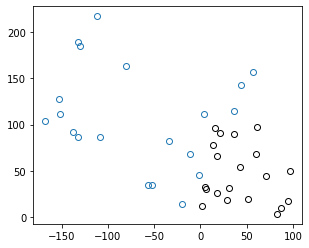

In [4]:
ax = plt.subplot(111)
plot(*s1.T)
plot(*s2.T, color="C0")

## Building the quads and hash codes

In [5]:
# all quads

quatidxs = list(combinations(np.arange(s1.shape[1]), 4))

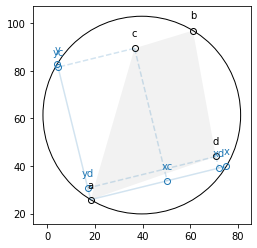

In [6]:
# What the quads look like

i = 12
a, b, c, d = s1[:, [q for q in quatidxs[i]]].T
a, b, c, d = reorganize(a, b, c, d)

plot_quad(a, b, c, d)

In [7]:
# What a hash code looks like

quad_hash(*s1[:, quatidxs[i]].T)

(-0.20260405510794677,
 0.13501078807206024,
 1.1724281082583718,
 1.486378631484014)

# Building all quads

In [8]:
# We have a lot of combinations
len(quatidxs)

4845

In [9]:
# For all them we pick the "good" ones and index the stars

quads1 = []
quads2 = []
stars1 = []
stars2 = []

for qi in quatidxs:
    _quad = reorganize(*s1[:, qi].T)
    if good_quad(*_quad):
        quads1.append(quad_hash(*_quad))
        stars1.append(_quad)
        
    _quad = reorganize(*s2[:, qi].T)
    if good_quad(*_quad):
        quads2.append(quad_hash(*_quad))
        stars2.append(_quad)
        
quads1 = np.array(quads1)
quads2 = np.array(quads2)
stars1 = np.array(stars1)
stars2 = np.array(stars2)

# Matching quads

In [10]:
# We now make the KDTree to work on the closest matches
from scipy.spatial import KDTree

kdtree = KDTree(quads1)

distances = [np.linalg.norm(q - quads1[kdtree.query(q)[1]]) for q in quads2]
best = np.argmin(distances)
test = quads2[best]
i = kdtree.query(test)[1]
closest_quad = quads1[i]

# this is our best match
i, test, closest_quad

(609,
 array([ 0.22276411,  0.48058129,  0.60180559, -0.01192513]),
 array([ 0.22410484,  0.48283663,  0.60201083, -0.01332132]))

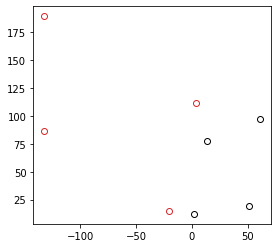

In [11]:
# Indeed it looks identical but transformed
S2 = stars2[best]
S1 = stars1[i]

plot(*S1)
plot(*S2, color="C3")

# Finding the transformation matrix

In [12]:
f = find_transform(S2, S1, return_function=True)

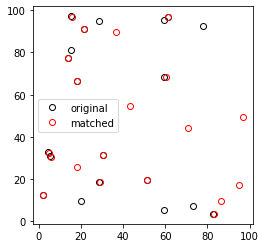

In [13]:
plot(*f(s2.T), label="original")
plot(*s1.T, color="red", label="matched")
#plot(*(np.linalg.inv(r)@np.pad(s2, (0, 1))).T[0:-1, 0:-1], color="C4", label="true transform")